In [4]:
from pyspark.sql import SparkSession
# start spark session configured for spark nlp
spark = SparkSession.builder \
     .master('local[*]') \
     .appName('Spark NLPm') \
     .config('spark.jars.packages', 
             'com.johnsnowlabs.nlp:spark-nlp_2.12:3.4.3') \
     .getOrCreate()

:: loading settings :: url = jar:file:/usr/local/lib/python3.9/site-packages/pyspark/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/hienpham/.ivy2/cache
The jars for the packages stored in: /Users/hienpham/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-760fc529-3d4d-46b2-b516-bd3b3980e97b;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;3.4.3 in central
	found com.typesafe#config;1.4.1 in central
	found org.rocksdb#rocksdbjni;6.5.3 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.603 in central
	found com.github.universal-automata#liblevenshtein;3.0.0 in central
	found com.google.code.findbugs#annotations;3.0.1 in central
	found net.jcip#jcip-annotations;1.0 in central
	found com.google.code.findbugs#jsr305;3.0.1 in central
	found com.google.protobuf#protobuf-java-util;3.0.0-beta-3 in central
	found com.google.protobuf#protobuf-java;3.0.0-beta-3 in central
	found com.google.code.gson#gson;2.3 in central
	found it.unimi.dsi#fastutil;7.0.12 in central
	found org.projectlombo

In [1]:
from textblob import TextBlob
sentence = "This is indeed a good book. The author did put a lot of effort to build the charactors being so special."
sentence = "1. Costs more than delivered to your door paper and online version combined.2. Very confusing to read. Not intuitive.3. Layout is a nightmare4. Cant find anything like in the paper or online version.5. Price went up even more.I cancelled until they get it right just like everyone else who has tried it. Big let down."
res = TextBlob(sentence)
print(res.sentiment.polarity)

0.04803174603174602


In [2]:
def getSentimentTB(benchmark, text):
        sentiment = TextBlob(text).sentiment.polarity
        if sentiment > float(benchmark):
            return float(1)
        elif sentiment < float(benchmark):
            return float(-1)
        else:
            return float(0)
        
sentence = "1. Costs more than delivered to your door paper and online version combined.2. Very confusing to read. Not intuitive.3. Layout is a nightmare4. Cant find anything like in the paper or online version.5. Price went up even more.I cancelled until they get it right just like everyone else who has tried it. Big let down."
res = getSentimentTB(0, sentence)
print(res)

1.0


In [3]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
def getSentimentVA(benchmark, text):
        sentiment = float(sid.polarity_scores(text).get("compound"))
        if sentiment > float(benchmark):
            return float(1)
        elif sentiment < float(benchmark):
            return float(-1)
        else:
            return float(0)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/hienpham/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [5]:
df = spark.read.option("header", True).csv('kindle_reviews.csv')
df = df.drop("_c0")
df = df.dropna()

In [10]:
from pyspark.sql.functions import udf, col, lit, when, expr
from pyspark.sql.types import DoubleType

benchmark = 0
udf_getTB = udf(getSentimentTB, DoubleType())
udf_getVA = udf(getSentimentVA, DoubleType())

df_tone = df.withColumn("tone_overall", expr("case when overall IN ('5','4') then float(1.0) " +
                       "when overall = '3' then float(0.0) " +
                       "else float(-1.0) end")).withColumn("tone_TB", udf_getTB(lit(benchmark), col("reviewText"))).withColumn("tone_VA", udf_getVA(lit(benchmark),col("reviewText")))
            

In [11]:
df_tone = df_tone.withColumn("diff_TB", when(col("tone_TB") != col("tone_overall"), False).otherwise(True))\
         .withColumn("diff_VA", when(col("tone_VA") != col("tone_overall"), False).otherwise(True))

In [85]:
df_tone.count()

978657

In [84]:
df_tone.where(col("diff_TB") == True).count()

800992

In [86]:
df_tone.where(col("diff_VA") == True).count()

781095

22/06/02 14:31:47 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 299962 ms exceeds timeout 120000 ms
22/06/02 14:31:47 WARN SparkContext: Killing executors is not supported by current scheduler.


In [23]:
df_tone

DataFrame[asin: string, helpful: string, overall: string, reviewText: string, reviewTime: string, reviewerID: string, reviewerName: string, summary: string, unixReviewTime: string, tone_overall: float, tone_TB: double, tone_VA: double, diff_TB: boolean, diff_VA: boolean]

In [24]:
df_fake_rv = df_tone.where(col("diff_VA") == False).groupBy("reviewerName").count().orderBy("count", ascending=False).limit(10)

In [26]:
df_fake_rv_pd = df_fake_rv.toPandas()

Text(0.5, 1.0, 'Top customers have the most fake reviews')

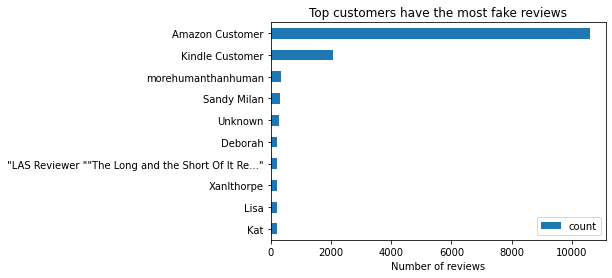

In [32]:
fig = df_fake_rv_pd.sort_values(by=['count']).plot(kind='barh', x='reviewerName', y='count')
fig.set_xlabel("Number of reviews")
fig.set_ylabel("")
fig.set_title("Top customers have the most fake reviews")

In [39]:
df_tone.filter("reviewerName = 'Amazon Customer'" anyd "diff_VA = False").take(10)

[Row(asin='B000F83SZQ', helpful='[1, 1]', overall='5', reviewText="I'd never read any of the Amy Brewster mysteries until this one..  So I am really hooked on them now.", reviewTime='02 19, 2014', reviewerID='A1FV0SX13TWVXQ', reviewerName='"Elaine H. Turley ""Montana Songbird"""', summary='I really liked it.', unixReviewTime='1392768000', tone_overall=1.0, tone_TB=1.0, tone_VA=0.0, diff_TB=True, diff_VA=False),
 Row(asin='B000F83SZQ', helpful='[1, 1]', overall='4', reviewText="Never heard of Amy Brewster. But I don't need to like Amy Brewster to like this book. Actually, Amy Brewster is a side kick in this story, who added mystery to the story not the one resolved it. The story brings back the old times, simple life, simple people and straight relationships.", reviewTime='03 22, 2014', reviewerID='A3DE6XGZ2EPADS', reviewerName='WPY', summary='Enjoyable reading and reminding the old times', unixReviewTime='1395446400', tone_overall=1.0, tone_TB=1.0, tone_VA=-1.0, diff_TB=True, diff_VA=F

Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 186, in manager
  File "/usr/local/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 74, in worker
  File "/usr/local/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 643, in main
    if read_int(infile) == SpecialLengths.END_OF_STREAM:
  File "/usr/local/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 564, in read_int
    raise EOFError
EOFError
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 186, in manager
  File "/usr/local/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 74, in worker
  File "/usr/local/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 643, in main
    if read_int(

In [105]:
df_tone.select("reviewText","tone_overall","tone_TB","tone_VA").where(expr("diff_TB = False and reviewerID = 'A13QTZ8CIMHHG4'")).take(50)

[Row(reviewText="Originally posted at: [...]Only Ava March could have pulled this off with such flair: a M/M Regency Vampire Romance. Talk about your sub genres. I went in with skeptical eyebrow raised - how could these elements work together? The eyebrow forgot to be skeptical halfway through the first page. From the first scene, with Raphael's desperate, lonely voyeurism, to the last, the reader is sucked into this dual world Ms. March has created for us.In order for the story to work convincingly, there are two parallel societies existing side by side. The strictly controlled manners and mores of Regency England stifle Aleric and keep Raphael isolated, while the libertine, violent nature of London's vampire society leaves Raphael feeling hollow and empty, and threatens them both. On the surface, neither one of our heroes are upright citizens, both of them guilty of debauched behavior and self-indulgence. But their failings are more a product of frustration and loneliness, of needing

In [8]:
from sparknlp.base import Finisher, DocumentAssembler
from sparknlp.annotator import (RegexTokenizer, Normalizer, SentenceDetector,
                                LemmatizerModel, StopWordsCleaner)
from pyspark.ml import Pipeline
from wordcloud import STOPWORDS

documentAssembler = DocumentAssembler() \
     .setInputCol('reviewText') \
     .setOutputCol('document')

sentenceDetector = SentenceDetector() \
    .setInputCols(["document"]) \
    .setOutputCol("sentence")

tokenizer = RegexTokenizer() \
     .setInputCols(['sentence']) \
     .setOutputCol('token') \
     .setPattern("[^\w']")

normalizer = Normalizer() \
     .setInputCols(['token']) \
     .setOutputCol('normalized') \
     .setLowercase(True)

lemmatizer = LemmatizerModel.pretrained() \
     .setInputCols(['normalized']) \
     .setOutputCol('lemma')

stopwords_cleaner = StopWordsCleaner() \
     .setInputCols(['lemma']) \
     .setOutputCol('clean_lemma') \
     .setCaseSensitive(False) \
     .setStopWords(list(STOPWORDS))

finisher = Finisher() \
     .setInputCols(['clean_lemma']) \
     .setCleanAnnotations(False)

pipeline = Pipeline() \
     .setStages([
           documentAssembler,
           sentenceDetector,
           tokenizer,
           normalizer,
           lemmatizer,
           stopwords_cleaner,
           finisher
     ])

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[ | ]lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[ / ]Download done! Loading the resource.
[OK!]


22/06/02 20:57:28 WARN StopWordsCleaner: Default locale set was [en_VN]; however, it was not found in available locales in JVM, falling back to en_US locale. Set param `locale` in order to respect another locale.


In [9]:
data = df_tone.select('reviewText')
equifax = pipeline.fit(data).transform(data)

In [ ]:
data.take(1)

In [10]:
from pyspark.sql.window import Window
from pyspark.sql.functions import monotonically_increasing_id, row_number
w = Window.orderBy(monotonically_increasing_id())

finished_clean_lemma = equifax.select('finished_clean_lemma').withColumn("index", row_number().over(w))
df_tone = df_tone.withColumn("index", row_number().over(w))

df_raw_features = finished_clean_lemma.join(df_tone, finished_clean_lemma.index == df_tone.index, 'inner')

In [13]:
df_raw_features.take(1)

22/06/02 20:59:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/02 20:59:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


KeyboardInterrupt: 

In [12]:
df_raw_features_cut.show(1)

22/06/02 20:57:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/02 20:57:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


KeyboardInterrupt: 

In [15]:
from pyspark.ml.feature import HashingTF as MLHashingTF
from pyspark.ml.feature import IDF as MLIDF
from pyspark.sql.types import DoubleType

htf = MLHashingTF(inputCol="finished_clean_lemma", outputCol="tf")
tf = htf.transform(df_raw_features_cut)
tf.cache()



22/06/02 18:30:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/02 18:30:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


DataFrame[finished_clean_lemma: array<string>, index: int, asin: string, helpful: string, overall: string, reviewText: string, reviewTime: string, reviewerID: string, reviewerName: string, summary: string, unixReviewTime: string, tone_overall: float, tone_TB: double, tone_VA: double, diff_TB: boolean, diff_VA: boolean, index: int, tf: vector]

In [16]:
idf = MLIDF(inputCol="tf", outputCol="idf")
tfidf = idf.fit(tf).transform(tf)


KeyboardInterrupt: 

In [ ]:
sum_ = udf(lambda v: float(v.values.sum()), DoubleType())
df_tfidf = tfidf.withColumn("features", sum_("idf"))

# from pyspark.ml.feature import VectorAssembler
# cols = ["idf_sum", "overall"]
# assembler = VectorAssembler()\
#   .setInputCols(cols)\
#   .setOutputCol("features")
# df_features = assembler.transform(df_tfidf)
df_features = df_features.where(col("features") > 0)

In [ ]:
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer()\
  .setInputCol("is_helpful")\
  .setOutputCol("label")
df_label = indexer.fit(df_features).transform(df_features)